# 0. IMPORT LIBRARIES

In [1]:
globals().clear
import time
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from datetime import datetime
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. LOAD AND FORMAT DATA

In [3]:
#Load Dataset
df = pd.read_csv('/Users/stevenwhang/Capstone/Datasets/df.csv')
DATETIME = df.DATETIME
df.shape

(10843, 75)

In [4]:
# Load dataset
path = '/content/drive/MyDrive/CapstoneProject/code/02. Machine Learning/data/'
file = 'df.csv'
df = pd.read_csv(path+file)
DATETIME = df.DATETIME
df.shape

(10758, 75)

# 2. CREATE THE MODEL: Train 60 days and predict 5 days

In [4]:
import time
file_name = 'XGB.60d.5d'
step_rows  = 5*22     #22*20 #110 (05 day)
total_rows = 10758         #      (24 months)
train_rows = 60*22 #420*22 #9240. (03 months)

scale_X = MinMaxScaler()
model = XGBRegressor(n_estimators=100, max_depth = 100, learning_rate=0.1, objective ='reg:squarederror', alpha = 10)

result = pd.DataFrame(columns = ['DATETIME', 'ACTUAL', 'PREDICTED', 'DIFFERENCE', 'TRAIN_DURATION'])

for i in range(0, total_rows - train_rows, step_rows):

  st = time.time()
  # 1. Obtain X and y
  train, test = df.iloc[i:train_rows+i, 1:], df.iloc[train_rows+i:train_rows+i+step_rows, 1:]
  X_train, y_train  = train.iloc[:,:-1], train.iloc[:,-1]
  X_test , y_test   = test.iloc[:,:-1] , test.iloc[:,-1]

  # 2. Scale X
  X_train = scale_X.fit_transform(X_train)
  X_test = scale_X.transform(X_test)
  
  # 3. Fit and Predict 
  model.fit(X_train,y_train)
  y_hat = model.predict(X_test)
  et = time.time()
  
  # 4. Save data with prediction
  fecha = DATETIME.iloc[train_rows+i:train_rows+i+step_rows]
  datos = {'DATETIME': fecha.ravel(), 'ACTUAL': y_test.ravel(), 'PREDICTED': y_hat.ravel(), 'DIFFERENCE': abs(y_hat.ravel()-y_test.ravel()), 'TRAIN_DURATION': np.full(y_hat.ravel().shape[0], et-st)}
  data = pd.DataFrame(data = datos)
  result = result.append(data)

  print("Count Down: ", math.trunc((total_rows-train_rows-i)/step_rows))
  #print(data.head())

Count Down:  85
Count Down:  84
Count Down:  83
Count Down:  82
Count Down:  81
Count Down:  80
Count Down:  79
Count Down:  78
Count Down:  77
Count Down:  76
Count Down:  75
Count Down:  74
Count Down:  73
Count Down:  72
Count Down:  71
Count Down:  70
Count Down:  69
Count Down:  68
Count Down:  67
Count Down:  66
Count Down:  65
Count Down:  64
Count Down:  63
Count Down:  62
Count Down:  61
Count Down:  60
Count Down:  59
Count Down:  58
Count Down:  57
Count Down:  56
Count Down:  55
Count Down:  54
Count Down:  53
Count Down:  52
Count Down:  51
Count Down:  50
Count Down:  49
Count Down:  48
Count Down:  47
Count Down:  46
Count Down:  45
Count Down:  44
Count Down:  43
Count Down:  42
Count Down:  41
Count Down:  40
Count Down:  39
Count Down:  38
Count Down:  37
Count Down:  36
Count Down:  35
Count Down:  34
Count Down:  33
Count Down:  32
Count Down:  31
Count Down:  30
Count Down:  29
Count Down:  28
Count Down:  27
Count Down:  26
Count Down:  25
Count Down:  24
Count Do

# 3. CREATE DATASET FOR METRICS AND GRAPH

In [5]:
result = result.reset_index(drop=True)
result.dropna(inplace = True)
result['DATETIME'] = pd.to_datetime(result['DATETIME'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
result['DATE']     = result.DATETIME.dt.date


# 4. CREATE THE GRAPH

<ipython-input-6-0196b442ae6c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  graph = pd.DataFrame(result.groupby('DATE')['PREDICTED','ACTUAL', 'DIFFERENCE'].mean())


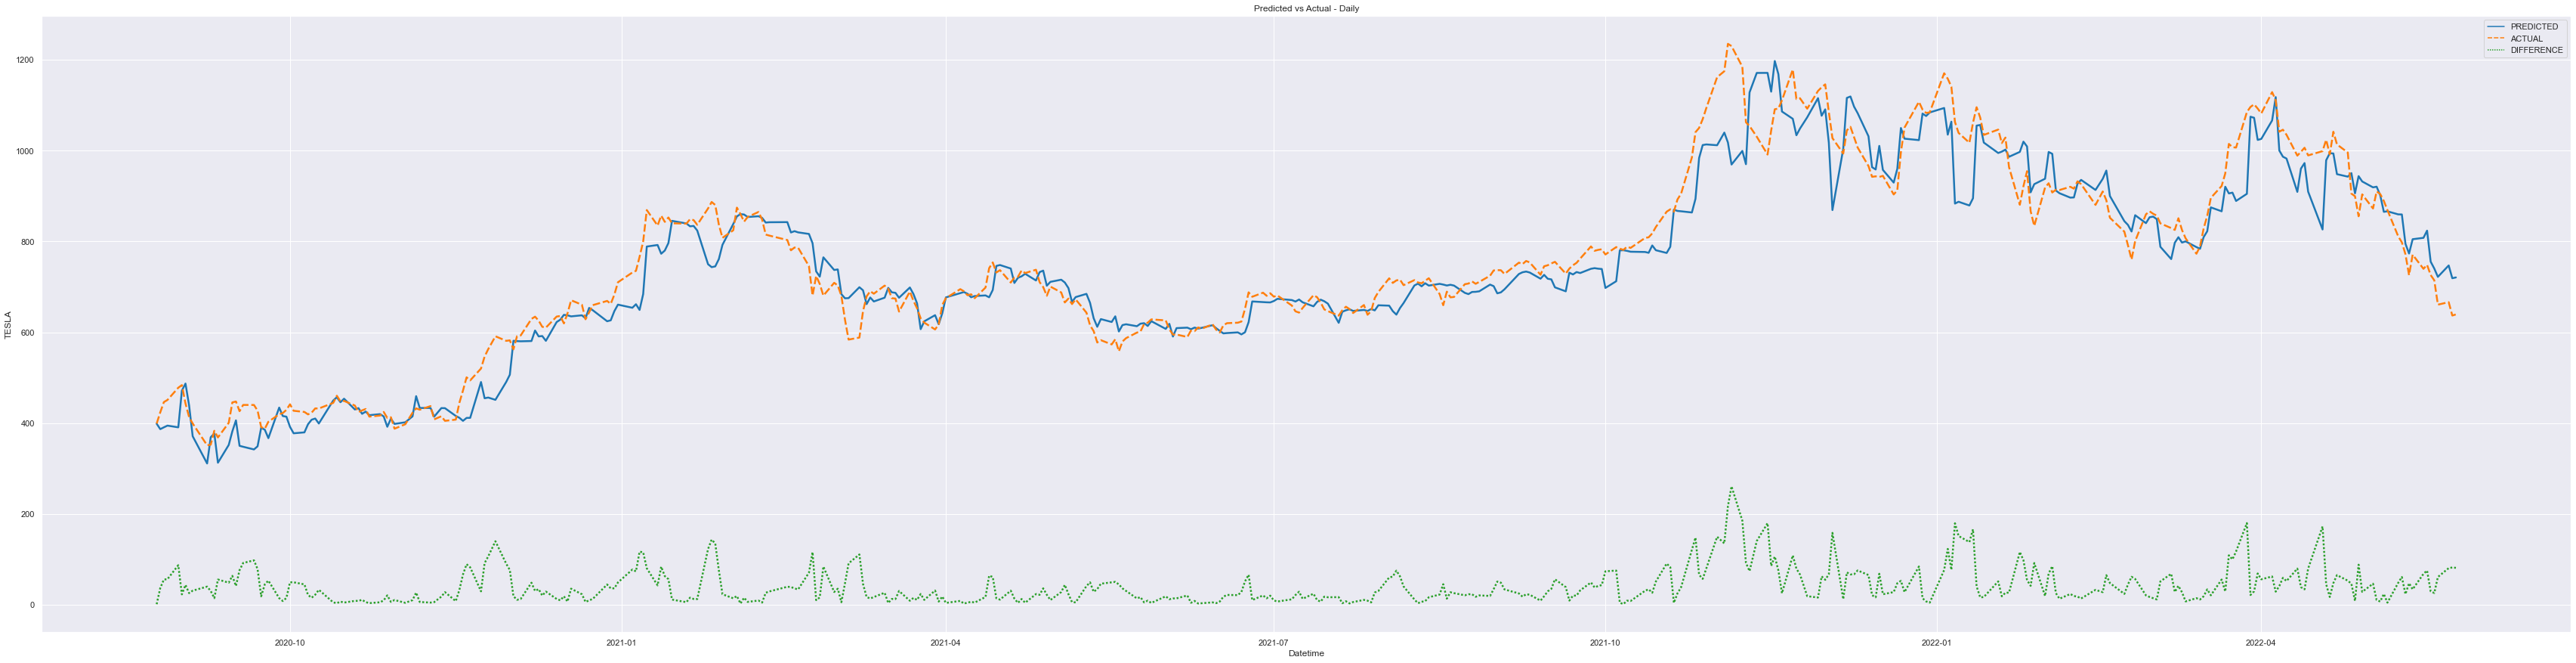

In [6]:
graph = pd.DataFrame(result.groupby('DATE')['PREDICTED','ACTUAL', 'DIFFERENCE'].mean())
plt.figure(figsize=(60,15))
linep = sns.lineplot(data = graph, palette="tab10", linewidth=2.5)
linep.set(xlabel='Datetime', ylabel='TESLA', title='Predicted vs Actual - Daily')
plt.show()

# 5. CALCULATE METRICS

In [7]:
#Check the overall RMSE value
rmse = np.sqrt(mean_squared_error(result['ACTUAL'], result['PREDICTED']))
rmse

57.75822351565246

In [8]:
#Check the overall MAPE value
mape = mean_absolute_percentage_error(result['ACTUAL'], result['PREDICTED'])
mape 

0.05376263354086046

In [9]:
#Check the mean difference
average = graph.DIFFERENCE.mean()
average

40.88679311934561

In [10]:
#Check the Mean Train Time
time = result.TRAIN_DURATION.mean()
time # Seconds

2.401000194771345

In [11]:
metrics = {'RMSE': [rmse], 'MAPE': [mape], 'MAE': [average], 'MTT': [time]}
metrics = pd.DataFrame(data = metrics, index = ['XGB'])

In [13]:
#Writting files
path = '/content/drive/MyDrive/CapstoneProject/code/02. Machine Learning/output/'
graph.to_csv(path+file_name+'-GRAPH.csv', index=True)
result.to_csv(path+file_name+'-RESULT.csv', index=True)
metrics.to_csv(path+file_name+'-METRICS.csv', index=True)